In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os

import numpy as np
import pandas as pd

from scipy.io import loadmat

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from utils import (Trainer)

# Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from umap import UMAP

from tqdm import tqdm

# model io
import joblib

# scoring
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score as NMI
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import NearestNeighbors

from sklearn.model_selection import train_test_split

In [3]:
cmap = plt.cm.Spectral

### Scoring methods

In [53]:
def co_ranking_matrix(dist_in, dist_latent):
    n = dist_in.shape[0]
    k_less_j = np.arange(n)[:,np.newaxis] < np.arange(n)
    ro = np.argsort(dist_in, axis=1, kind='mergesort')
    r = np.argsort(dist_latent, axis=1, kind='mergesort')
    Q_kl = np.zeros((n,n))
    for k in range(n):
        for l in range(n):
            Q_kl[k,l] = np.sum((ro == k) * (r == l))
    return Q_kl

def q_nx(Q_kl, K):
    n = Q_kl.shape[0]
    return np.sum(Q_kl[:K,:K])/K/n

def q_nd(Q_kl, Ks, kappa=None):
    if kappa == None:
        kappa = Ks
    n = Q_kl.shape[0]
    rect = Q_kl[:Ks,:]
    close = np.abs(np.arange(Ks)[:,np.newaxis]-rect) <= kappa
    reg = rect * close
    return np.sum(reg)/Ks/n
    

    
def rmse(dist_in, dist_latent):
    return (np.mean((dist_in - dist_latent)**2, axis=1))**.5

def kruskal_stress(dist_in, dist_latent):
    return (np.sum((dist_in - dist_latent)**2, axis=1)/np.sum(dist_latent**2, axis=1))

def residual_variance(dist_in, dist_latent):
    rss = np.sum((dist_in - dist_latent)**2, axis=1)
    tss = (np.sum(dist_in - dist_in.mean(axis=1)))**2
    return 1 - rss/tss

def spearman_rank(dist_in, dist_latent):
    ro = np.argsort(dist_in, axis=1, kind='mergesort')+1
    r = np.argsort(dist_latent, axis=1, kind='mergesort')+1
    n = ro.shape[0]
    return 1 - 6 * np.sum((ro-r)**2/(n*(n**2-1)), axis=1)

def neighborhood_loss(X_in, X_latent, k=9):
    nbrs_in = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(X_in)
    nbrs_latent = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(X_latent)
    _, idx_in = nbrs_in.kneighbors(X_in)
    _, idx_latent = nbrs_latent.kneighbors(X_latent)
    inter = np.array([np.intersect1d(x,y).shape[0] for (x,y) in zip([*idx_in], [*idx_latent])])
    return 1 - inter/k

def kmeans_nmi(X, true_labels, **kwargs):
    n_clusters = np.unique(true_labels).shape[0]
    labels = KMeans(n_clusters=n_clusters, **kwargs).fit_predict(X)
    return NMI(true_labels, labels)

In [30]:
def eval_model(save_dir, dataset_name, max_size=10000):

    trainer = joblib.load(f"{save_dir}/{dataset_name}-model.joblib")
    
    X = trainer.dataset.X.detach().numpy()
    y = trainer.dataset.y.detach().numpy().ravel()
    
    if X.shape[0] > max_size:
        _, X, _, y = train_test_split(X, y, test_size=max_size, random_state=42, stratify=y)
    
    results = trainer.transform(X=X, lle=True)
    x_ae = results['X_ae']
    x_aelle = results['Y']
    
    x_pca = PCA(n_components=trainer.d_out).fit_transform(X)    
    x_umap = UMAP(n_neighbors=trainer.n_neighbors, n_components=trainer.d_out).fit_transform(X)
    x_lle = LocallyLinearEmbedding(n_neighbors=trainer.n_neighbors, n_components=trainer.d_out).fit_transform(X)
    
    return X, x_umap
        
    
    dist_in = squareform(pdist(X))
    nmi_in = kmeans_nmi(X, y, n_init=20)
    dr_dict = {'pca': x_pca, 'lle': x_lle, 'umap': x_umap, 'ae': x_ae, 'ae_lle': x_aelle}
    params_dict = dict(n_neighbors=trainer.n_neighbors,
                    d_out=trainer.d_out,
                    d_ae=trainer.net.d_latent)
    res_dict = dict()
    for algo, res in dr_dict.items():
        dist_latent = squareform(pdist(res))
        Q = co_ranking_matrix(dist_in, dist_latent)
        res_dict[algo] = {
            'coranking_score': q_nd(Q,trainer.n_neighbors),
            'rmse': rmse(dist_in, dist_latent).mean(),
            'kruskal': kruskal_stress(dist_in, dist_latent).mean(),
            'res_var': residual_variance(dist_in, dist_latent).mean(),
            'spearman_rho': spearman_rank(dist_in, dist_latent).mean(),
            'neighborhood_loss': neighborhood_loss(X, res, k=trainer.n_neighbors).mean(),
            'nmi': kmeans_nmi(res, y, n_init=20),
            'nmi_in': nmi_in,
        }
        
    joblib.dump({
        'res_dict': res_dict,
        'params_dict': params_dict,
    }, f"{save_dir}/{save_dir.rsplit('/')[-1]}-{dataset_name}-embeddings.joblib")

    return {
        'res_dict': res_dict,
        'params_dict': params_dict,
    }

In [33]:
# X1, X2 = eval_model(**eval_params['lle_3_ae_3'], dataset_name='orl')
X1.shape, X2.shape

((400, 1024), (400, 3))

In [37]:
d1 = squareform(pdist(X1))
d2 = squareform(pdist(X2))

In [43]:
%%time
q = co_ranking_matrix(d1,d2)

CPU times: user 1min 26s, sys: 46.9 ms, total: 1min 26s
Wall time: 1min 27s


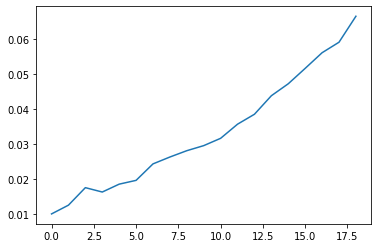

In [49]:
plt.plot([q_nx(q, k) for k in range(1,20)])

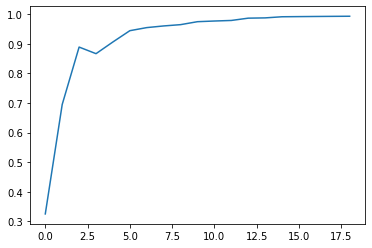

In [54]:
plt.plot([q_nd(q, k) for k in range(1,20)])

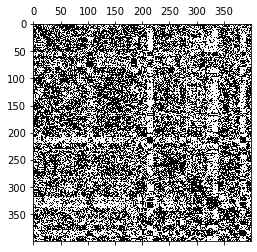

In [44]:
plt.spy(q)

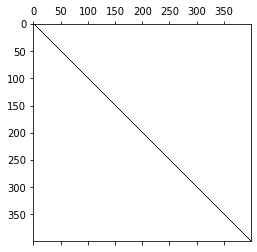

In [42]:
plt.spy(q)

In [18]:
eval_params = {
    'lle_2_ae_2': {
        'save_dir': '../models/lle_2_ae_2',
    },
    'lle_3_ae_3': {
        'save_dir': '../models/lle_3_ae_3',
    },
    'lle_2_ae_not_2': {
        'save_dir': '../models/lle_2_ae_not_2',
    },
    'lle_3_ae_not_3': {
        'save_dir': '../models/lle_3_ae_not_3',
    },
    'lle_ae_different': {
        'save_dir': '../models/lle_2_ae_2',
    },
    
}

In [29]:
res = eval_model(**eval_params['lle_ae_different'], dataset_name='orl')
pd.DataFrame(res['res_dict']).T.round(3)

,coranking,rmse,kruskal,res_var,spearman,neighborhood_loss,nmi,nmi_in
pca,NaN,697.061,7.450000e-01,-9.246837e+26,0.101,0.639,0.562,0.77
lle,NaN,1511.980,2.701208e+08,-4.260240e+27,0.094,0.628,0.658,0.77
umap,NaN,1508.639,1.863837e+05,-4.241374e+27,0.099,0.463,0.777,0.77
ae,NaN,1286.683,3.165300e+01,-3.076233e+27,0.087,0.661,0.539,0.77
ae_lle,NaN,1511.977,2.587479e+08,-4.260226e+27,0.091,0.661,0.548,0.77
